In [1]:
import sys
sys.path.insert(1,'./decoders')
sys.path.insert(1,'./Instances_models')
sys.path.insert(1,'./Evaluators')
sys.path.insert(1,'./Utils')
from TSP_decoder import TSPDecoder
from TSP_instance import TSPInstance
from Datasets import FNN_dataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os    
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

burma14 : 3323

In [2]:
instance  = TSPInstance(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Instances_data_TSP\burma14.dat')
decoder = TSPDecoder(instance)

In [3]:
chromossomes = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\chromosomes_1.txt')
fitness = np.loadtxt(r'C:\Users\Felipe\Projetos\Generative models optimization\Generative-model-optimization\Initial Populations\fitness_1.txt')
lista = [chromossomes,fitness]


In [4]:
print(len(chromossomes))

10000


In [5]:
tours = np.zeros((len(chromossomes),14))
for i in np.arange(len(chromossomes)):
    tours[i] = np.argsort(chromossomes[i]) 
    

In [6]:
print(tours[3])

[ 2.  3.  9.  7.  8. 12.  5.  4.  1. 10.  0.  6. 13. 11.]


In [7]:
init_pop = pd.DataFrame(data=chromossomes)

In [8]:
init_pop['Fitness'] = fitness

In [9]:
print(f'maximo: {fitness.max()}  minimo {fitness.min()}')

maximo: 8829.0  minimo 4176.0


In [ ]:
worst = np

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(tours,fitness,test_size=0.2,random_state=42)



In [12]:
class Population_dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float)
        self.y = torch.tensor(y,dtype=torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        chromossome = self.x[idx]
        fit = self.y[idx]
        return chromossome,fit
    

In [13]:
class VAautoencoder(nn.Module):
    def __init__(self,input_dim,h_dim,z_dim):
        super().__init__()
        
        self.fitness = nn.Linear(z_dim,1 )
        #encoder
        self.recorrente_encoder = nn.LSTM(input_dim,h_dim,num_layers=3,batch_first=True)
        
        self.sigma = nn.Linear(h_dim,z_dim)
        self.mu = nn.Linear(h_dim,z_dim)

        #decode
        self.LSTM_decoder = nn.LSTM(z_dim,h_dim ,num_layers=3,batch_first=True)
        self.z_2hidden = nn.Linear(z_dim,h_dim)
        self.output = nn.Linear(h_dim,input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    
    def encode(self,x):
        x = torch.unsqueeze(x,2)
        saida,(h_n,c_n) = self.recorrente_encoder(x)
        h_n = h_n[-1]
        mu = self.mu(h_n)
        sigma = self.sigma(h_n)
        return mu ,sigma
    
    def decode(self,z):
        out,hidden = self.LSTM_decoder(z)
        output = self.output(out)
        return output
    
    def fitness_pred(self,x):
        fit = self.fitness(x)
        return fit
    
    def forward(self,x):
        mu,sigma = self.encode(x)
        epsilon = torch.rand_like(sigma)
        z_reparametrizado = mu + torch.exp(sigma/2)*epsilon
        pred_value = self.fitness_pred(z_reparametrizado)
        x_reconstruido = self.decode(z_reparametrizado)
        return x_reconstruido,mu,sigma,pred_value
        

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMPUT_DIM = 14
H_DIM = 10
Z_DIM = 7
NUM_EPOCH = 500
LA_RATE = 3e-3

In [15]:
modelVAE = VAautoencoder(IMPUT_DIM,H_DIM,Z_DIM)
optimizerVAE = torch.optim.Adam(modelVAE.parameters(),lr=LA_RATE)
Cross_Entropy_Loss = nn.CrossEntropyLoss()
MSE_Loss = nn.MSELoss()
loss_per_epoch_VAE = np.zeros(NUM_EPOCH)
prediction_loss = np.zeros(NUM_EPOCH)

In [16]:
train_dataset = Population_dataset(X_train,Y_train)
test_dataset = Population_dataset(X_test,Y_test)

train_dataloader = DataLoader(train_dataset,batch_size=100,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=False)

In [17]:

def train_model(model,optimizer,Cross_Entropy_Loss,MSE_Loss,NUM_EPOCH,dataloader,loss_per_epoch,prediction_loss):
    for epoch in range(NUM_EPOCH):
        for index, (x,y) in enumerate(dataloader):
            
            x_reconstructed, mu, sigma,pred = model(x)
    

 
            
            x_tour = np.argsort(x_reconstructed.detach().numpy())
            x_tour = torch.tensor(x_tour,dtype=torch.float)
            #print(x_tour.shape)
            x = x.type(torch.float)
            recons_loss= Cross_Entropy_Loss(x_tour,x)
            
            
            kl_div = -0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            pred = torch.squeeze(pred,dim=1)
            fit_error = MSE_Loss(pred,y)
            
            optimizer.zero_grad() 
            loss_val = recons_loss + kl_div  + fit_error
            
            loss_val.backward()
            optimizer.step()
            
            loss_per_epoch[epoch] = loss_val 
            prediction_loss[epoch] = fit_error
            
            
        if epoch % 100 ==0:   
            print(f"Epoch {epoch}, Erro Treino: {loss_per_epoch[epoch]}")
            
            

In [18]:

train_model(modelVAE,optimizerVAE,Cross_Entropy_Loss,MSE_Loss,NUM_EPOCH,train_dataloader,loss_per_epoch_VAE,prediction_loss)

Epoch 0, Erro Treino: 44756960.0
Epoch 100, Erro Treino: 1530772.25
Epoch 200, Erro Treino: 593316.3125
Epoch 300, Erro Treino: 380972.84375
Epoch 400, Erro Treino: 276408.25


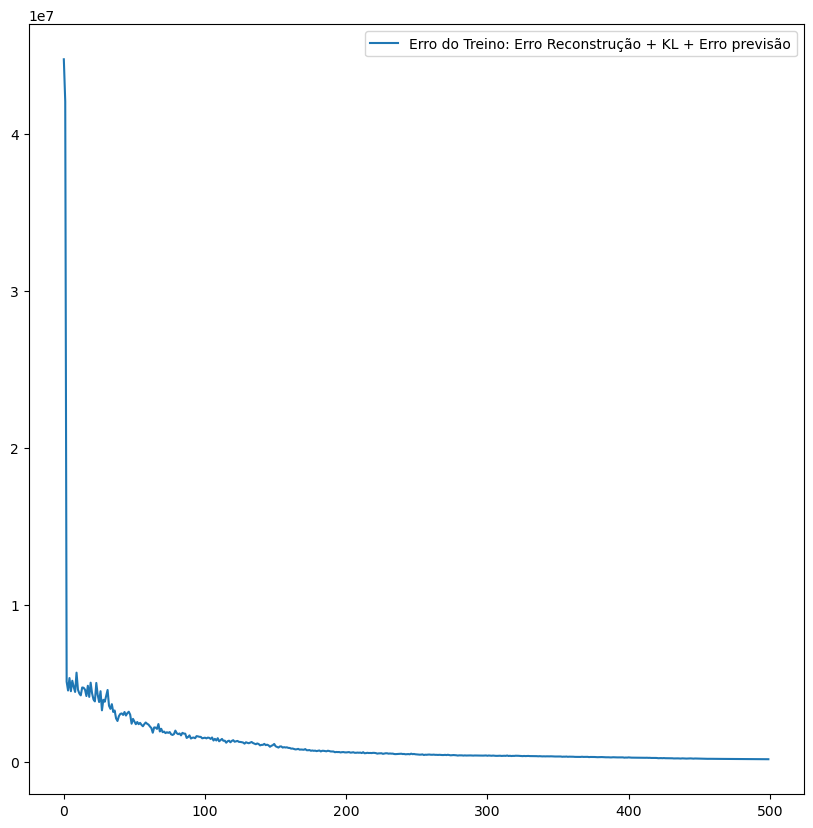

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(loss_per_epoch_VAE, label='Erro do Treino: Erro Reconstrução + KL + Erro previsão')
plt.legend()
plt.show()

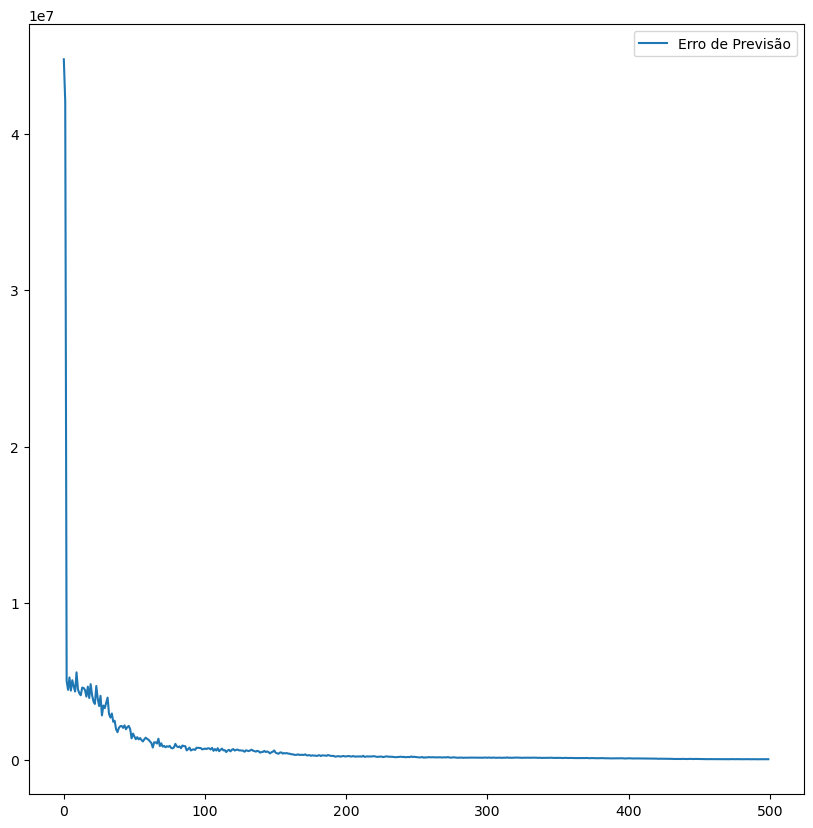

In [20]:
plt.figure(figsize=(10,10))
plt.plot(prediction_loss, label='Erro de Previsão')
plt.legend()
plt.show()

In [21]:
with torch.no_grad():
    mu,sigma = modelVAE.encode(torch.tensor(X_train,dtype=torch.float))
    epsilon = torch.randn_like(sigma)
    z_train = mu + torch.exp(sigma/2)*epsilon
    

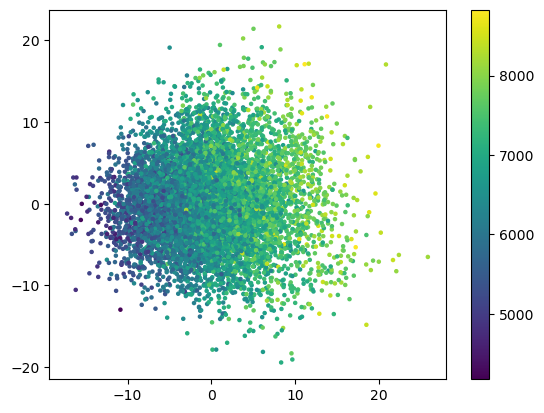

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(z_train)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=Y_train, cmap='viridis', s=5)
plt.colorbar()
plt.savefig('espaco_latente.png',format='png')
plt.show()

In [23]:
pca.explained_variance_ratio_

array([0.30515843, 0.25169184])

In [83]:
pop = np.argsort(fitness)
best = pop[0]
worst = pop[-1]
print(f'best:{best}  worst:{worst}')

best:8141  worst:3635


In [84]:
best_ind = torch.tensor(chromossomes[best],dtype=torch.float)
best_ind = torch.reshape(best_ind,(1,14))

worst_ind = torch.tensor(chromossomes[worst],dtype=torch.float)
worst_ind = torch.reshape(worst_ind,(1,14))

In [93]:
z_best = np.zeros((100,7))
z_worst = np.zeros((100,7))
with torch.no_grad():
    mu,sigma = modelVAE.encode(best_ind)
    epsilon = torch.rand_like(sigma)
    mu2,sigma2 = modelVAE.encode(worst_ind)
    epsilon2 = torch.rand_like(sigma2)
    for i in np.arange(100):
        
        
        z_w = mu2 + torch.exp(sigma2/2)*epsilon2
        z_b = mu + torch.exp(sigma/2)*epsilon
        z_best[i] = z_b
        z_worst[i]  = z_w
    

[[  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282 -15.8203001   16.57818794
   16.5238781    6.40679598]
 [  3.98906517 -15.95692158   5.88515282

In [95]:
z_best =  torch.tensor(z_best,dtype=torch.float)
z_worst =  torch.tensor(z_worst,dtype=torch.float)
with torch.no_grad():
    LSB = modelVAE.decode(z_best)
    LSW = modelVAE.decode(z_worst)

tensor([[-0.2287,  0.2789,  0.1861,  ..., -0.1878, -0.2297,  0.1255],
        [-0.2195,  0.2770,  0.1830,  ..., -0.1951, -0.2165,  0.1266],
        [-0.2166,  0.2737,  0.1803,  ..., -0.2004, -0.2081,  0.1287],
        ...,
        [-0.2157,  0.2639,  0.1752,  ..., -0.2134, -0.1977,  0.1391],
        [-0.2157,  0.2639,  0.1752,  ..., -0.2134, -0.1977,  0.1391],
        [-0.2157,  0.2639,  0.1752,  ..., -0.2134, -0.1977,  0.1391]])


tensor([[-0.2287,  0.2790,  0.1860,  ..., -0.1879, -0.2299,  0.1255],
        [-0.2194,  0.2771,  0.1826,  ..., -0.1952, -0.2168,  0.1266],
        [-0.2164,  0.2737,  0.1796,  ..., -0.2004, -0.2085,  0.1288],
        ...,
        [-0.2151,  0.2632,  0.1732,  ..., -0.2149, -0.1988,  0.1405],
        [-0.2151,  0.2632,  0.1732,  ..., -0.2148, -0.1988,  0.1405],
        [-0.2151,  0.2632,  0.1732,  ..., -0.2148, -0.1988,  0.1405]])


In [98]:
fitness_best = []
fitness_worst = []
for e in LSB:
    fitness_best.append(decoder.decode(e))

for w in LSW:
    fitness_worst.append(decoder.decode(w))



tensor([-0.2287,  0.2790,  0.1860,  0.0647,  0.1224, -0.2416,  0.0229,  0.0202,
        -0.2094, -0.0952, -0.2218, -0.1879, -0.2299,  0.1255])
tensor([-0.2194,  0.2771,  0.1826,  0.0599,  0.1295, -0.2271,  0.0284,  0.0424,
        -0.2213, -0.1030, -0.1961, -0.1952, -0.2168,  0.1266])
tensor([-0.2164,  0.2737,  0.1796,  0.0581,  0.1312, -0.2225,  0.0294,  0.0536,
        -0.2249, -0.1070, -0.1830, -0.2004, -0.2085,  0.1288])
tensor([-0.2152,  0.2704,  0.1775,  0.0578,  0.1313, -0.2218,  0.0292,  0.0592,
        -0.2257, -0.1088, -0.1758, -0.2039, -0.2033,  0.1309])
tensor([-0.2148,  0.2678,  0.1762,  0.0582,  0.1310, -0.2224,  0.0287,  0.0618,
        -0.2255, -0.1095, -0.1719, -0.2061, -0.2000,  0.1325])
tensor([-0.2146,  0.2661,  0.1754,  0.0586,  0.1308, -0.2233,  0.0284,  0.0629,
        -0.2251, -0.1096, -0.1699, -0.2075, -0.1981,  0.1337])
tensor([-0.2146,  0.2649,  0.1750,  0.0591,  0.1307, -0.2242,  0.0281,  0.0633,
        -0.2248, -0.1096, -0.1689, -0.2084, -0.1971,  0.1346])

In [99]:
print(fitness_best)

[5910.0, 7451.0, 6965.0, 6989.0, 7003.0, 7003.0, 7003.0, 7003.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0]


In [100]:
print(fitness_worst)

[5910.0, 7451.0, 6965.0, 6989.0, 7003.0, 7003.0, 7003.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 7399.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0, 6869.0]
